In [1]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 80.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 32.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.8/267.8 kB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 22.2 MB/s e

**Modules**

In [2]:
import qiskit as qt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

cuda


In [4]:
from torch.utils.data import Dataset, DataLoader
import os
image_names = os.listdir("../input/balanced-ben/zip_output")
images_path = "/kaggle/input/balanced-ben/zip_output"

In [5]:
import random

def random_rotation(image):
    angle = random.randint(-30,30)
    return transforms.functional.rotate(image,angle)

import torchvision.transforms as transforms
my_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(random_rotation),
    transforms.ToTensor(),
#     transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         )
])

In [6]:
import torch
import cv2
class retinaDataset(Dataset):
    def __init__(self, imagepath="../input/balanced-ben/zip_output", total=None,transform=my_transform):
        self.df = pd.read_csv("/kaggle/input/balanced-ben/dr_labels.csv")
        
        if (total is not None):
            self.df = self.df[:total]
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        
        # no pre-processing
        img = Image.open(img_path)
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)

In [7]:
len(image_names)
train_dataset = retinaDataset(total=len(image_names))
# train_dataset = retinaDataset(total=20000)
len(image_names)

20126

(torch.Size([3, 224, 224]), tensor(4), 20126)

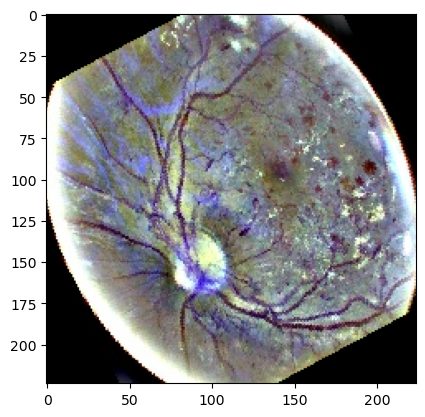

In [8]:
img, label = train_dataset[2]

plt.imshow(img.permute(1,2,0))
img.shape, label, train_dataset.__len__()

# QUANTUM

In [9]:
import torch
from torch import nn
from torch import Tensor, nn
from math import ceil
from qiskit_ibm_runtime import IBMBackend, Options
from typing import Any, List, Optional, Tuple
from zipfile import ZipFile

import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import (Estimator, IBMBackend, Options,
                                QiskitRuntimeService, RuntimeJob)

In [10]:
# Convolution, Batch Normalization, and Activation Class

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x

In [11]:
''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y

In [12]:
# Stochastic Depth Module

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor

In [13]:
# Residual Bottleneck Block with Expansion Factor = N as defined in 
# Mobilenet-V2 paper with Squeeze and Excitation Block and Stochastic Depth.
class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x

In [14]:

import numpy as np
from qiskit import QuantumCircuit, Aer, assemble
from qiskit.circuit import Parameter

class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self._circuit = QuantumCircuit(n_qubits)
        all_qubits = [i for i in range(n_qubits)]

        self.theta_params = [Parameter(f'theta{i}') for i in range(7)]

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_params[0], all_qubits)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_params[1], 0)
        self._circuit.ry(self.theta_params[2], 1)
        self._circuit.ry(self.theta_params[3], 2)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_params[4], 0)
        self._circuit.ry(self.theta_params[5], 1)
        self._circuit.ry(self.theta_params[6], 2)
        self._circuit.measure_all()
        
        self.backend = backend
        #self.backend = Aer.get_backend("qasm_simulator")
        self.shots = shots

    def run(self, thetas):
        parameter_binds = {param: value for param, value in zip(self.theta_params, thetas.tolist())}
#         parameter_binds=thetas.tolist()
        bound_circuit = self._circuit.bind_parameters(parameter_binds)

        qobj = assemble(bound_circuit,
                        shots=(self.shots))

        job = self.backend.run(qobj)
        result = job.result()

        counts = result.get_counts(bound_circuit)

        expects = np.zeros(8)
        for k, key in enumerate(['000', '001', '010', '011', '100', '101', '110', '111']):
            perc = counts.get(key, 0) / self.shots
            expects[k] = perc
        return expects

In [15]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(channel="ibm_cloud", token="d2DUg18hN8ad8X0eQ9vRR0NZ44beT6v6QyfDwYfxIv25", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c047b8c0f84443c68960f1da8c9b6ceb:05b3ef99-4a28-4920-94bf-e0fc67aec43d::")
# # QiskitRuntimeService.save_account(channel="ibm_cloud", token="d2DUg18hN8ad8X0eQ9vRR0NZ44beT6v6QyfDwYfxIv25", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c047b8c0f84443c68960f1da8c9b6ceb:05b3ef99-4a28-4920-94bf-e0fc67aec43d::")
# service = QiskitRuntimeService()
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import SparsePauliOp
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

# # Initialize the Qiskit Runtime service
# service = QiskitRuntimeService()
# options = Options() 
# options.optimization_level = 2 
# options.resilience_level = 0 

# # Create a QuantumCircuit instance
# backend = service.get_backend("ibmq_qasm_simulator")
# circuit = MyQuantumCircuit(3, backend, 10000)._circuit  # Use ._circuit to get the QuantumCircuit instance

# # Define set of parameters for the circuit
# # parameter_values = [1, 2, 1, 4, 5, 6, 8]
# parameter_values=[
#     [1, 2, 1, 4, 5, 6, 8 ],
#     [2, 3, 0, 2, 1, 7, 9 ]
# ]

# # for parameter_values in parameter_values_list:
# #     test_val.append(circuit.run(torch.tensor(parameter_values)).tolist())
    
# observables = SparsePauliOp("ZZZ") 
# with Session(service=service, backend=backend) as session: 
#     estimator = Estimator(session=session, options=options) 
#     for parameter in parameter_values:
#         job = estimator.run([circuit], [observables], parameter)  
#         result = job.result() 

# print(f">>> Expectation value: {result}")
# print(job.status())
# print(circuit.draw('mpl'))

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_cloud", token="d2DUg18hN8ad8X0eQ9vRR0NZ44beT6v6QyfDwYfxIv25", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c047b8c0f84443c68960f1da8c9b6ceb:05b3ef99-4a28-4920-94bf-e0fc67aec43d::")
QiskitRuntimeService.save_account(channel="ibm_cloud", token="d2DUg18hN8ad8X0eQ9vRR0NZ44beT6v6QyfDwYfxIv25", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c047b8c0f84443c68960f1da8c9b6ceb:05b3ef99-4a28-4920-94bf-e0fc67aec43d::")
service = QiskitRuntimeService()
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService,Sampler, Session, Options

# Initialize the Qiskit Runtime service
service = QiskitRuntimeService()
options = Options() 
options.optimization_level = 2 
options.resilience_level = 0 

# Create a QuantumCircuit instance
backend = service.get_backend("ibmq_qasm_simulator")
circuit = MyQuantumCircuit(3, backend, 10000)._circuit  # Use ._circuit to get the QuantumCircuit instance

# Define set of parameters for the circuit
# parameter_values = [1, 2, 1, 4, 5, 6, 8]
parameter_values=[
    [1, 2, 1, 4, 5, 6, 8],
    [2, 3, 0, 2, 1, 7, 9]
]

# for parameter_values in parameter_values_list:
#     test_val.append(circuit.run(torch.tensor(parameter_values)).tolist())
    
with Session(service=service, backend=backend) as session: 
#     estimator = Estimator(session=session, options=options) 
#     sampler = Sampler(session=session,options=options)
    sampler = Sampler(session=session)
    for parameter in parameter_values:
        job = sampler.run([circuit], parameter)  
        result = job.result() 

print(f">>> Probabilities : {result}")
print(job.status())

base_primitive._run_primitive:INFO:2023-08-20 22:28:00,814: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-08-20 22:28:01,941: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

>>> Probabilities : SamplerResult(quasi_dists=[{1: 0.0055, 2: 0.15125, 6: 0.2515, 4: 0.113, 5: 0.094, 0: 0.00125, 3: 0.13075, 7: 0.25275}], metadata=[{'shots': 4000}])
JobStatus.DONE


In [17]:
# backend = Aer.get_backend("qasm_simulator")
# circuit = MyQuantumCircuit(3,backend, 1000)  # Use ._circuit to get the QuantumCircuit instance

# parameter_values_list = [
#     [1, 2, 1, 4, 5, 6, 8, 9 , 0.4322, 0.00, 0.21312],
#     [2, 3, 0, 2, 1, 7, 9, 8 , 0.21312, 0.00, 0.1234]
# ]
# test_val=[]

# for parameter_values in parameter_values_list:
#     test_val.append(circuit.run(torch.tensor(parameter_values)).tolist())
# test_val

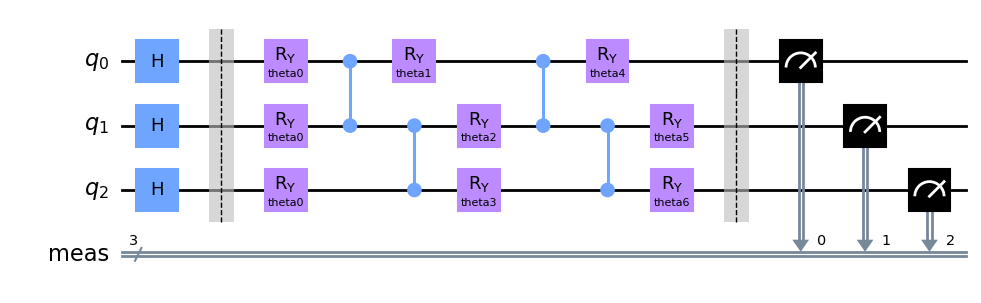

In [18]:
circuit.draw(output='mpl')

In [19]:
class QuantumFunction(torch.autograd.Function):
    """custom autograd function that uses a quantum circuit"""

    @staticmethod
    def forward(
        ctx,
        batch_inputs: Tensor,
        qc: MyQuantumCircuit,
    ) -> Tensor:
        """forward pass computation"""
#         print(batch_inputs.tolist())
        ctx.save_for_backward(batch_inputs)
        ctx.qc = qc
        ctx.shift = torch.pi / 2,
#         result=[]
#         for parameter_values in batch_inputs.tolist():
        features = batch_inputs
#             result.append(qc.run(torch.tensor(parameter_values)).tolist())
#         return torch.tensor(result)#qc.run(batch_inputs)
        flattened_tensor = batch_inputs.flatten()
        with Session(service=service, backend=backend) as session: 
            sampler = Sampler(session=session, options=options)
            job = sampler.run([circuit], flattened_tensor[:7].tolist())  
            result = job.result() 
#         qc.run(flattened_tensor)
        return features

    @staticmethod
    def backward(
        ctx,
        grad_output: Tensor
    ):
        """backward pass computation using parameter shift rule"""
        batch_inputs = ctx.saved_tensors[0]
        qc = ctx.qc

        shifted_inputs_r = torch.empty(batch_inputs.shape)
        shifted_inputs_l = torch.empty(batch_inputs.shape)

        # loop over each input in the batch
        for i, _input in enumerate(batch_inputs):

            # loop entries in each input
            for j in range(len(_input)):

                # compute parameters for parameter shift rule
                d = torch.zeros(_input.shape)
                d[j] = ctx.shift
                shifted_inputs_r[i, j] = _input + d
                shifted_inputs_l[i, j] = _input - d

        # run gradients in batches
        exps_r=[]
        exps_l=[]
        print(shifted_inputs_r.tolist())
        for parameter_values in shifted_inputs_r.tolist():
            exps_r.append(qc.run(parameter_values).tolist())
        
        for parameter_values in shifted_inputs_l.tolist():
            exps_l.append(qc.run(torch.tensor(parameter_values)).tolist())

        return (torch.tensor(exps_r) - torch.tensor(exps_l)).float() * grad_output.float(), None, None

In [20]:
class QuantumLayer(torch.nn.Module):
    """a neural network layer containing a quantum function"""

    def __init__(
        self,
        n_qubits: int,
#         estimator: Estimator,
        backend,
        shots:int
    ):
        super().__init__()
        self.qc = MyQuantumCircuit(
            n_qubits=n_qubits,
#             estimator=estimator,
            backend=backend,
            shots=shots
        )

    def forward(self, xs: Tensor) -> Tensor:
        """forward pass computation"""

        result = QuantumFunction.apply(xs, self.qc)

        if xs.shape[0] == 1:
            return result.view((1, 1))
        return result

In [21]:
'''Efficient-net Class'''
from qiskit.primitives import Estimator
estimator = Estimator(options=Options().__dict__)
class EfficientNet(nn.Module):
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.quantum = QuantumLayer(3,backend,10000)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        x = self.quantum(x)
        x = self.features(x)
        x = self.avgpool(x)
        
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [22]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [23]:
# def test():
#     version = 'b0'
#     width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
#     net = EfficientNet(width_mult, depth_mult, dropout_rate, estimator)
#     x = torch.rand(1, 3, res, res)
#     y = net(x)
#     print(y.size())
    
# test()

In [24]:
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 5)
model = model.to(device) # Load model to device.

In [25]:
model

EfficientNet(
  (quantum): QuantumLayer()
  (features): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (1): MBConvN(
      (expand): Identity()
      (depthwise_conv): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (se): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (pointwise_conv): ConvBnAct(
        (conv): Conv2d(32, 16, 

In [26]:
checkpoint = torch.load('../input/final-chkp/final_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epochs']

In [27]:
start_epoch

150

In [28]:
# Define loss function and optimizer
num_classes = 5
lr = 1e-4
num_epochs = 20
batch_size = 32
criterion = nn.CrossEntropyLoss() # y Cross-Entropy Loss for Multi-classification
optimizer = optim.Adam(model.parameters() , lr = 0.001)

In [29]:
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Splitting the Dataset into Training and Testing Dataset
# train , test = train_test_split(train_dataset , test_size = 0.08)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [30]:
# train_dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

In [31]:
# Define the number of epochs and other necessary variables
from tqdm import tqdm

num_epochs = 1
total_samples = len(train_dataloader)

for epoch in range(start_epoch,start_epoch + num_epochs):
    running_loss = 0.0
    correct_output = 0
    total_output = 0
    model.train()
    for data,target in tqdm(train_dataloader):  # Assuming you have a DataLoader for training data
        optimizer.zero_grad()
        
        # image and labels as data and target
        data = data.to(device=device)
        target = target.to(device=device)
        
        #outputs from model
        outputs = model(data)
        
        # loss function
        loss = criterion(outputs, target)
        loss.backward()
        # optimizer
        optimizer.step()
        running_loss += loss.item()

        _,predictions = outputs.max(1)
        correct_output += (target==predictions).sum()
        total_output += predictions.shape[0]
        
    accuracy = float(correct_output/total_output)*100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total_samples}, Accuracy : {accuracy}")

100%|██████████| 629/629 [17:40<00:00,  1.69s/it]

Epoch 151/1, Loss: 0.5032717603094438, Accuracy : 80.23949265480042


In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': num_epochs,
}
torch.save(checkpoint,'model_checkpoint.pth')

In [38]:
def check_accuracy(model, loader):
    model.eval()
    correct_output = 0
    total_output = 0
    prediction = []
    actual = []
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
#             print(y)
            score = model(x)
            _,predictions = score.max(1)
#             print(predictions)
            prediction.append(predictions)
            actual.append(y)
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")
    return prediction , actual

In [33]:
test_dataset = retinaDataset(total=len(image_names))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

(torch.Size([3, 224, 224]), tensor(1), 20126)

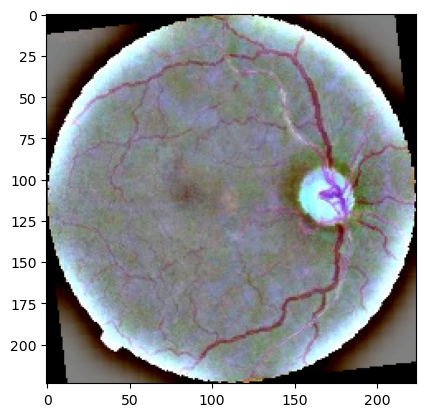

In [35]:
img, label = test_dataset[0]

plt.imshow(img.permute(1,2,0))
img.shape, label, train_dataset.__len__()

In [ ]:
# # Checking the Accuracy of Model in the Training Dataset
# trainPrediction , actualTrain = check_accuracy(model, train_dataloader)
# # check_accuracy(model, train_dataloader)

In [39]:
# Check the Accuracy of the Model in the Testing Dataset
testPrediction , actualTest = check_accuracy(model , test_dataloader)

100%|██████████| 629/629 [17:16<00:00,  1.65s/it]

out of 20126 , total correct: 17015 with an accuracy of 84.54238176345825


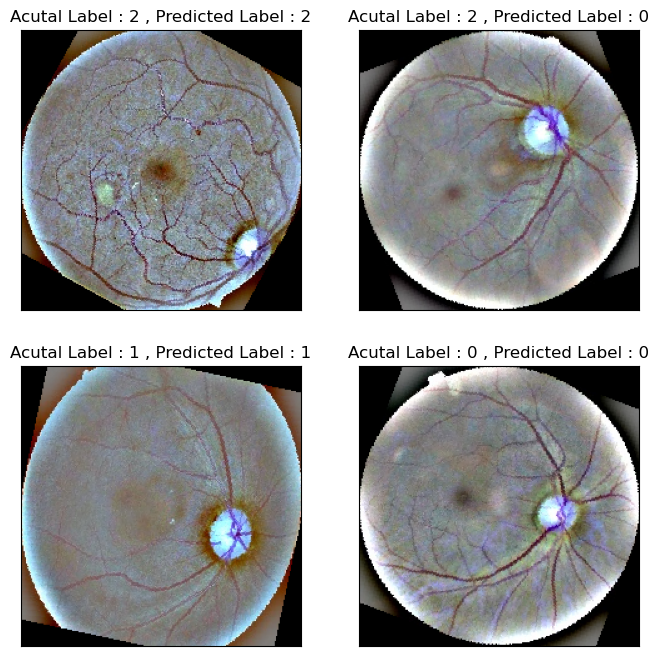

In [62]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

plt.figure(figsize = (8,8))
for index in range(0,4):
    plt.subplot(2,2,index+1)
    plt.imshow(np.transpose(images[index], (1, 2, 0)))
    plt.title(f"Acutal Label : {labels[index].item()} , Predicted Label : {actualTest[0][index].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [64]:
def converting_numpy(matrix):
    data = []
    for listData in range(len(matrix)):
        for index in range(len(matrix[listData])):
            data.append(int(matrix[listData][index]))
    res = np.array(data)
    return res

# Call the Function to converting the Numpy Array
prediction = converting_numpy(testPrediction)
actuall = converting_numpy(actualTest)

In [66]:
# Display the Accuracy of the Model in the Testing Dataset
print(f"Here is the Accuracy of the Model in the Testing Dataset is : {accuracy_score(actuall , prediction)}")
# Display the F1 Score of the Model in the Testing Dataset
print(f"Here is the F1 Score of the Model in the Testing Dataset is : {f1_score(actuall , prediction , average='macro')}")
# Display the Recall Score of the Model in the Testing Dataset
print(f"Here is the Recall Score of the Model in the Testing Dataset is : {recall_score(actuall , prediction, average = 'macro')}")
# Display the Precision Score of the Model in the Testing Dataset
print(f"Here is the Precision Score of the Model in the Testing Dataset is : {precision_score(actuall , prediction, average = 'macro')}")

Here is the Accuracy of the Model in the Testing Dataset is : 0.8454238298718076
Here is the F1 Score of the Model in the Testing Dataset is : 0.7968795803448281
Here is the Recall Score of the Model in the Testing Dataset is : 0.7636366623764254
Here is the Precision Score of the Model in the Testing Dataset is : 0.8527013845225987
